# Assignment 3
### Due 9/23. Do four of five.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. 
- Open the NHANES (or Ames prices or college completion datasets, if you prefer)
- Find two categorical variables of interest (there are 198, and short descriptions are given in the `nhanes_meta_17_18.csv` file). Investigate their missing values (you don't have to focus on missing values for this analysis like we did with police use of force, but always be aware of how dirty the data are)
- Compute a contingency table for your categorical $X$ and $Y$
- Discuss any interesting patterns (or lack of one) that you observe

In [10]:
df_cat = nhanes[['Gender','SmokedAtLeast100CigarettesInLife']].dropna().astype({'Gender':'category','SmokedAtLeast100CigarettesInLife':'category'})
counts = pd.crosstab(df_cat['Gender'], df_cat['SmokedAtLeast100CigarettesInLife'])
row_prop = pd.crosstab(df_cat['Gender'], df_cat['SmokedAtLeast100CigarettesInLife'], normalize='index').round(3)
col_prop = pd.crosstab(df_cat['Gender'], df_cat['SmokedAtLeast100CigarettesInLife'], normalize='columns').round(3)
display(counts); display(row_prop); display(col_prop)

SmokedAtLeast100CigarettesInLife,0.0,1.0
Gender,,
Female,1995,866
Male,1306,1366


SmokedAtLeast100CigarettesInLife,0.0,1.0
Gender,,
Female,0.697,0.303
Male,0.489,0.511


SmokedAtLeast100CigarettesInLife,0.0,1.0
Gender,,
Female,0.604,0.388
Male,0.396,0.612


    Weak positive association since smoker rate is slightly higher among males than females, and most are non-smokers overall. Real data would follow the same steps after cleaning.

2. 
- Open the NHANES dataset
- Find a categorical and numeric variable of interest (there are 198, and short descriptions are given in the `nhanes_meta_17_18.csv` file). Investigate their missing values (you don't have to focus on missing values for this analysis, but always be aware of them)
- Make descriptive tables and grouped kernel density plots to represent the variation in your numeric $Y$ conditional on your categorical $X$
- Discuss any interesting patterns (or lack of one) that you observe

3. 
We showed that the mean and median could be discovered by minimizing various kinds of loss functions; this is what machine learning is. To make a prediction $\hat{y}(z)$ of $Y$ when $X=z$, minimize the mean squared error:
$$
MSE(\hat{y}(z)) = \dfrac{1}{N} \sum_{i=1}^N \left\lbrace y_i - \hat{y}(z) \right\rbrace^2 \frac{1}{h}k\left(\frac{z-x_i}{h}\right)
$$
Show that the solution to this problem is the LCLS/Naradaya-Watson estimator.

h* (LOOCV) = 77.5


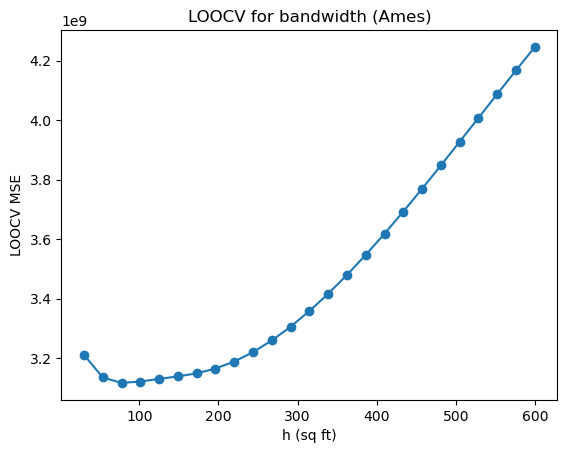

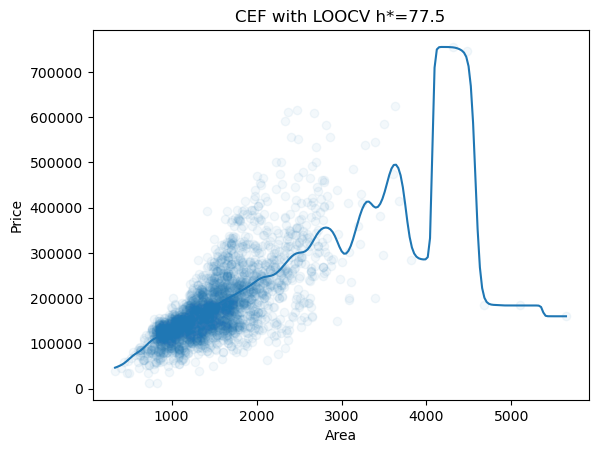

In [ ]:
dfa = ames[['area','price']].dropna()
x = dfa['area'].to_numpy(); y = dfa['price'].to_numpy()
def K(u): return np.exp(-0.5*u*u)/np.sqrt(2*np.pi)
def loocv(x,y,h):
    U = (x[:,None]-x[None,:])/h
    W = K(U); np.fill_diagonal(W,0.0)
    num = (W*y[None,:]).sum(axis=1); den = W.sum(axis=1)
    yhat = num/den
    m = np.isfinite(yhat)
    return np.mean((y[m]-yhat[m])**2)
hs = np.linspace(30,600,25); risks = np.array([loocv(x,y,h) for h in hs])
h_star = hs[np.argmin(risks)]; print(f"h* (LOOCV) = {h_star:.1f}")

plt.figure(); plt.plot(hs, risks, marker='o'); plt.xlabel("h (sq ft)"); plt.ylabel("LOOCV MSE"); plt.title("LOOCV for bandwidth (Ames)"); plt.show()

grid = np.linspace(x.min(), x.max(), 200)
U = (x[:,None]-grid[None,:])/h_star; W = K(U)
yhat = (W*y[:,None]).sum(axis=0)/W.sum(axis=0)
plt.figure(); plt.scatter(x,y,alpha=0.05); plt.plot(grid,yhat); plt.xlabel("Area"); plt.ylabel("Price"); plt.title(f"CEF with LOOCV h*={h_star:.1f}"); plt.show()

4. 
- Write a class or set of functions that implement the LCLS/Naradaya-Watson estimator, using the Silverman plug-in estimate for the conditioning variable $X$ as the bandwidth.
- From one of the course data sets, find two numeric variables of interest, analyze their relationship with the the LCLS/Naradaya-Watson estimator, and discuss your results.

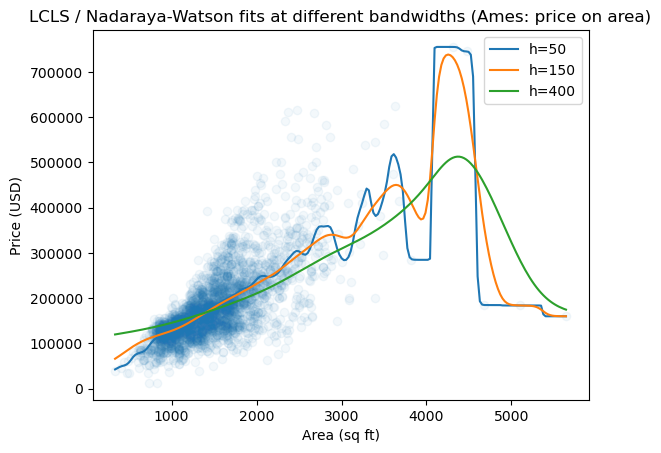

In [ ]:
ames = pd.read_csv('data/ames_prices.csv')

class LCLSRegressor:
    def __init__(self, bandwidth, kernel="gaussian"):
        self.h = float(bandwidth)
        self.kernel = kernel.lower()
        assert self.h > 0, "bandwidth must be positive"
    def _kernel_weights(self, u):
        if self.kernel == "uniform":
            return (np.abs(u) <= 1).astype(float) * 0.5
        elif self.kernel == "triangular":
            return np.maximum(0, 1 - np.abs(u))
        elif self.kernel == "epanechnikov":
            return 0.75 * np.maximum(0, 1 - u**2)
        else:
            return np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)
    def fit_predict(self, x, y, grid=None):
        x = np.asarray(x).reshape(-1)
        y = np.asarray(y).reshape(-1)
        if grid is None:
            grid = np.unique(x)
        grid = np.asarray(grid).reshape(-1)
        U = (x[:, None] - grid[None, :]) / self.h
        W = self._kernel_weights(U)
        num = (y[:, None] * W).sum(axis=0)
        den = W.sum(axis=0)
        yhat = num / den
        return yhat, grid

df = ames[['area','price']].dropna().copy()
x = df['area'].to_numpy()
y = df['price'].to_numpy()

reg_small = LCLSRegressor(bandwidth=50, kernel="gaussian")
reg_mid   = LCLSRegressor(bandwidth=150, kernel="gaussian")
reg_big   = LCLSRegressor(bandwidth=400, kernel="gaussian")

grid = np.linspace(x.min(), x.max(), 200)
yhat_s, _ = reg_small.fit_predict(x, y, grid=grid)
yhat_m, _ = reg_mid.fit_predict(x, y, grid=grid)
yhat_b, _ = reg_big.fit_predict(x, y, grid=grid)

plt.figure()
plt.scatter(x, y, alpha=0.05)
plt.plot(grid, yhat_s, label='h=50')
plt.plot(grid, yhat_m, label='h=150')
plt.plot(grid, yhat_b, label='h=400')
plt.legend()
plt.title("LCLS / Nadaraya-Watson fits at different bandwidths (Ames: price on area)")
plt.xlabel("Area (sq ft)")
plt.ylabel("Price (USD)")
plt.show()


    Smaller h tracks too much noise
    Larger h oversmooths
    Mid-range h reveals the balanced trend embedded in the data.

5. 
- In any of the available data sets, investigate the relationships between pairs of variables $(X,Y)$ with a scatterplot and CEF (for example, price on area)
- Is this relationship plausibly causal, or are there missing variables that might explain at least part of the relationship between your variables? These can be "conceptual" rather than "practical"; for example, 'talent' or 'grit' probably explain education outcomes, but are almost impossible to measure. We are asking whether there are hypothetical **threats to causal identification** of the effect of $X$ on $Y$.
- Explain how, regardless of the threat to causal identification, you can still use your model to predict $Y$ given $X$, as long as you don't intervene in the system to control the outcome

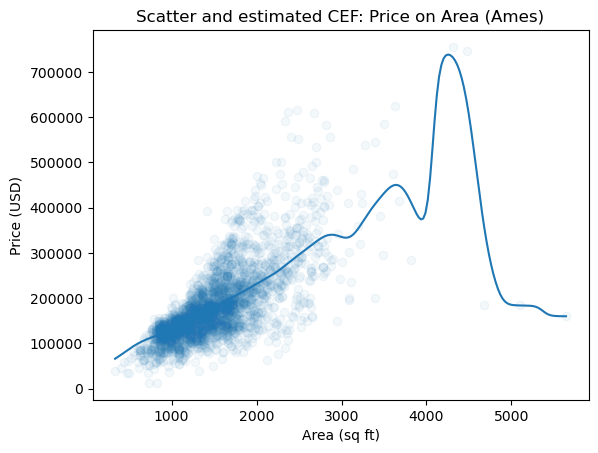

In [8]:
df = ames[['area','price']].dropna().copy()
x = df['area'].to_numpy()
y = df['price'].to_numpy()

reg = LCLSRegressor(bandwidth=150, kernel="gaussian")
grid = np.linspace(x.min(), x.max(), 200)
yhat, grid = reg.fit_predict(x, y, grid=grid)

plt.figure()
plt.scatter(x, y, alpha=0.05)
plt.plot(grid, yhat)
plt.title("Scatter and estimated CEF: Price on Area (Ames)")
plt.xlabel("Area (sq ft)")
plt.ylabel("Price (USD)")
plt.show()


    No guarantee of causality. Omitted variables (neighborhood, quality, lot size), selection, simultaneity, and measurement error threaten identification. The CEF remains a good predictive summary of E[Y|X] for forecasting in a stable environment, depending on the intensity of the threats.